In [15]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import torch

In [1]:
import os

def save_img_from_npy(npy_path, img_path):
    img = np.load(npy_path)
    img = np.expand_dims(img, axis=0)
    img = img * 255
    img = np.transpose(img, (1, 2, 0))
    cv2.imwrite
    cv2.imwrite(img_path, img)



# target_path = "pretrain/no_sub"
# npy_path = "Dataset/no_sub"

# os.makedirs(target_path, exist_ok=True)

# for file in tqdm(os.listdir(npy_path)):
#     if file.endswith(".npy"):
#         save_img_from_npy(npy_path + "/" + file, target_path + "/" + file[:-4] + ".png")


In [2]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os

transform_train = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        
        ])
dataset = datasets.ImageFolder(os.path.join("Foundation_model", ''), transform=transform_train)

In [3]:
dataset

Dataset ImageFolder
    Number of datapoints: 89104
    Root location: Foundation_model/
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
           )

In [4]:
import torch
import timm
import numpy as np

from einops import repeat, rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block

def random_indexes(size : int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches : torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)

        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]

        return patches, forward_indexes, backward_indexes

class MAE_Encoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 num_layer=12,
                 num_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))
        self.shuffle = PatchShuffle(mask_ratio)

        self.patchify = torch.nn.Conv2d(3, emb_dim, patch_size, patch_size)

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.layer_norm = torch.nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding

        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')

        return features, backward_indexes

class MAE_Decoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 num_layer=4,
                 num_head=3,
                 ) -> None:
        super().__init__()

        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim))

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.head = torch.nn.Linear(emb_dim, 3 * patch_size ** 2)
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:] # remove global feature

        patches = self.head(features)
        mask = torch.zeros_like(patches)
        mask[T-1:] = 1
        mask = take_indexes(mask, backward_indexes[1:] - 1)
        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

class MAE_ViT(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 encoder_layer=12,
                 encoder_head=3,
                 decoder_layer=4,
                 decoder_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img, mask = self.decoder(features,  backward_indexes)
        return predicted_img, mask

class ViT_Classifier(torch.nn.Module):
    def __init__(self, encoder : MAE_Encoder, num_classes=10) -> None:
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = torch.nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits


if __name__ == '__main__':
    shuffle = PatchShuffle(0.75)
    a = torch.rand(16, 2, 10)
    b, forward_indexes, backward_indexes = shuffle(a)
    print(b.shape)

    img = torch.rand(2, 3, 32, 32)
    encoder = MAE_Encoder()
    decoder = MAE_Decoder()
    features, backward_indexes = encoder(img)
    print(forward_indexes.shape)
    predicted_img, mask = decoder(features, backward_indexes)
    print(predicted_img.shape)
    loss = torch.mean((predicted_img - img) ** 2 * mask / 0.75)
    print(loss)

/usr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/arnesh/.local/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


torch.Size([4, 2, 10])
torch.Size([16, 2])
torch.Size([2, 3, 32, 32])
tensor(0.3494, grad_fn=<MeanBackward0>)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mae = MAE_ViT( image_size=64, patch_size=4, emb_dim=192, encoder_layer=12, encoder_head=3, decoder_layer=4, decoder_head=3, mask_ratio=0.75).to(device)
# pretrain_model/model_vit_t.pth
mae.load_state_dict(torch.load("pretrain_model/model_vit_t_best.pth", map_location='cpu'))
encoder = mae.encoder
encoder = encoder.float()
encoder = encoder.to(device)

In [6]:
model =  ViT_Classifier(encoder, num_classes=3).to(device)

In [7]:
model

ViT_Classifier(
  (patchify): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
  (transformer): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=False)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): Identity()
    

In [8]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

loss_fn = torch.nn.CrossEntropyLoss()
acc_fn = lambda logit, label: torch.mean((logit.argmax(dim=-1) == label).float())


TEST_SIZE = 0.1
train_size = int(len(dataset) * (1 - TEST_SIZE))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size] , generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

optimizer = AdamW(model.parameters(), lr=1e-4)

epochs = 20

scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)

best_acc = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    for img, label in tqdm(train_loader):
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        logit = model(img)
        loss = loss_fn(logit, label)
        acc = acc_fn(logit, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    model.eval()
    test_loss = 0
    test_acc = 0
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        logit = model(img)
        loss = loss_fn(logit, label)
        acc = acc_fn(logit, label)
        test_loss += loss.item()
        test_acc += acc.item()
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print(f"Epoch {epoch+1}/{epochs} : Train Loss {train_loss:.4f} Train Acc {train_acc:.4f} Test Loss {test_loss:.4f} Test Acc {test_acc:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "MAE_classifier.pth")
    scheduler.step()

100%|██████████| 2507/2507 [03:57<00:00, 10.54it/s]


Epoch 1/20 : Train Loss 0.4029 Train Acc 0.8296 Test Loss 0.2382 Test Acc 0.9090


100%|██████████| 2507/2507 [03:57<00:00, 10.55it/s]


Epoch 2/20 : Train Loss 0.2493 Train Acc 0.9047 Test Loss 0.2820 Test Acc 0.8875


100%|██████████| 2507/2507 [03:47<00:00, 11.02it/s]


Epoch 3/20 : Train Loss 0.2030 Train Acc 0.9253 Test Loss 0.2538 Test Acc 0.9008


100%|██████████| 2507/2507 [03:44<00:00, 11.19it/s]


Epoch 4/20 : Train Loss 0.1768 Train Acc 0.9362 Test Loss 0.1740 Test Acc 0.9347


100%|██████████| 2507/2507 [03:47<00:00, 11.03it/s]


Epoch 5/20 : Train Loss 0.1565 Train Acc 0.9442 Test Loss 0.1489 Test Acc 0.9478


100%|██████████| 2507/2507 [03:47<00:00, 11.01it/s]


Epoch 6/20 : Train Loss 0.1431 Train Acc 0.9499 Test Loss 0.0982 Test Acc 0.9662


100%|██████████| 2507/2507 [03:46<00:00, 11.04it/s]


Epoch 7/20 : Train Loss 0.1229 Train Acc 0.9575 Test Loss 0.1517 Test Acc 0.9441


100%|██████████| 2507/2507 [03:48<00:00, 10.95it/s]


Epoch 8/20 : Train Loss 0.1107 Train Acc 0.9624 Test Loss 0.0800 Test Acc 0.9760


100%|██████████| 2507/2507 [03:46<00:00, 11.09it/s]


Epoch 9/20 : Train Loss 0.0977 Train Acc 0.9669 Test Loss 0.1182 Test Acc 0.9601


100%|██████████| 2507/2507 [03:42<00:00, 11.25it/s]


Epoch 10/20 : Train Loss 0.0826 Train Acc 0.9726 Test Loss 0.0710 Test Acc 0.9731


100%|██████████| 2507/2507 [03:40<00:00, 11.36it/s]


Epoch 11/20 : Train Loss 0.0700 Train Acc 0.9766 Test Loss 0.0680 Test Acc 0.9757


100%|██████████| 2507/2507 [03:40<00:00, 11.36it/s]


Epoch 12/20 : Train Loss 0.0614 Train Acc 0.9803 Test Loss 0.0421 Test Acc 0.9877


100%|██████████| 2507/2507 [03:40<00:00, 11.38it/s]


Epoch 13/20 : Train Loss 0.0528 Train Acc 0.9834 Test Loss 0.0459 Test Acc 0.9852


100%|██████████| 2507/2507 [03:40<00:00, 11.37it/s]


Epoch 14/20 : Train Loss 0.0428 Train Acc 0.9866 Test Loss 0.0369 Test Acc 0.9885


100%|██████████| 2507/2507 [03:40<00:00, 11.38it/s]


Epoch 15/20 : Train Loss 0.0345 Train Acc 0.9896 Test Loss 0.0296 Test Acc 0.9925


100%|██████████| 2507/2507 [03:40<00:00, 11.37it/s]


Epoch 16/20 : Train Loss 0.0272 Train Acc 0.9918 Test Loss 0.0426 Test Acc 0.9842


100%|██████████| 2507/2507 [03:46<00:00, 11.09it/s]


Epoch 17/20 : Train Loss 0.0226 Train Acc 0.9939 Test Loss 0.0294 Test Acc 0.9918


100%|██████████| 2507/2507 [03:48<00:00, 10.99it/s]


Epoch 18/20 : Train Loss 0.0180 Train Acc 0.9953 Test Loss 0.0115 Test Acc 0.9966


100%|██████████| 2507/2507 [03:49<00:00, 10.95it/s]


Epoch 19/20 : Train Loss 0.0153 Train Acc 0.9960 Test Loss 0.0135 Test Acc 0.9959


100%|██████████| 2507/2507 [03:48<00:00, 10.95it/s]


Epoch 20/20 : Train Loss 0.0136 Train Acc 0.9965 Test Loss 0.0151 Test Acc 0.9963


In [9]:
print(len(train_dataset), len(test_dataset))

80193 8911


In [10]:
#AUC macro and micro

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

encoder = MAE_ViT( image_size=64, patch_size=4, emb_dim=192, encoder_layer=12, encoder_head=3, decoder_layer=4, decoder_head=3, mask_ratio=0.75).encoder

encoder = encoder.float()
encoder = encoder.to(device)

model =  ViT_Classifier(encoder, num_classes=3).to(device)
model.load_state_dict(torch.load("MAE_classifier.pth", map_location='cpu'))

model = model.to(device)
print(model)

ViT_Classifier(
  (patchify): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
  (transformer): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=False)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): Identity()
    

In [11]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

TEST_SIZE = 0.1
train_size = int(len(dataset) * (1 - TEST_SIZE))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size] , generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


acc = 0
y_true = []
y_pred = []
model.eval()

for img, label in tqdm(test_loader):
    img, label = img.to(device), label.to(device)
    logit = model(img)
    y_true.extend(label.cpu().numpy())
    y_pred.extend(logit.cpu().detach().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

lb = LabelBinarizer()
y_true = lb.fit_transform(y_true)
y_pred = lb.transform(y_pred.argmax(axis=1))

auc_macro = roc_auc_score(y_true, y_pred, average='macro')
auc_micro = roc_auc_score(y_true, y_pred, average='micro')

print(f"AUC Macro : {auc_macro:.4f} AUC Micro : {auc_micro:.4f}")

#Acc1

from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
print(f"Accuracy : {acc:.4f}")



100%|██████████| 8911/8911 [00:37<00:00, 235.40it/s]

AUC Macro : 0.9958 AUC Micro : 0.9958
Accuracy : 0.9944


In [12]:
#ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import torch.nn.functional as F
from tqdm import tqdm
model.eval()

test_loss = 0.0
test_accuracy = 0.0
y_true = []
y_pred_probs = []  # Store predicted probabilities instead of predicted labels

with torch.no_grad():
    for i, (images, labels) in  tqdm(enumerate(test_loader) , total=len(test_loader)):
        images = images.to(device)
        labels = labels.to(device)
        images = images.float()
        
        # Forward pass
        outputs = model(images)

        _, preds = torch.max(outputs, 1)
        test_accuracy += (preds == labels).sum().item()

        # Softmax to get predicted probabilities
        probs = F.softmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(probs.cpu().numpy())


100%|██████████| 8911/8911 [00:32<00:00, 272.96it/s]


In [13]:
#CLASS wise AUC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer


y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

lb = LabelBinarizer()
y_true = lb.fit_transform(y_true)

aucs = []
for i in range(y_true.shape[1]):
    auc = roc_auc_score(y_true[:, i], y_pred_probs[:, i])
    aucs.append(auc)

print(aucs)

    

[np.float64(0.9997147326347926), np.float64(0.9994024051803886), np.float64(0.9999301729893227)]


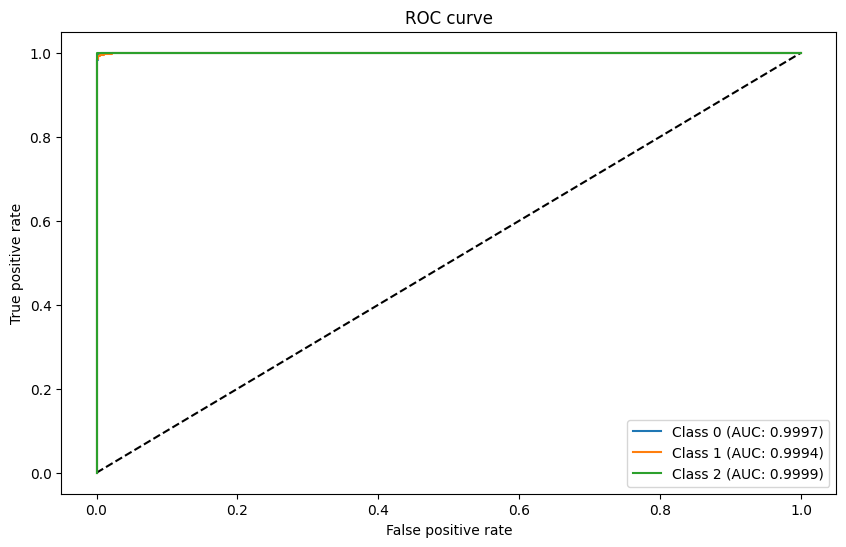

In [14]:
#ROC
fpr = dict()
tpr = dict()

for i in range(y_true.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])

plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(y_true.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC: {aucs[i]:.4f})')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.legend()
plt.show()
